In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import random
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from xgboost import XGBRegressor

In [2]:
dataset = pd.read_csv('siswave3v4impute3.csv', low_memory=False)

In [3]:
print('Total rows in the dataset is',len(dataset))
#print(pd.DataFrame(dataset['rearn'].describe()))

Total rows in the dataset is 1501


In [4]:
missing_data_value = dataset[dataset['rearn'].isnull()]
all_values = dataset.dropna(subset = ['rearn'])
all_values = all_values.dropna(axis = 1)

In [5]:
len(all_values)
all_values.shape

(1348, 212)

In [6]:
all_values = pd.get_dummies(all_values)
corr = all_values.corr()
corr['column_names'] = corr.index

In [7]:
sorted_correlation = corr[['rearn', 'column_names']]
sorted_correlation['rearn'] = abs(sorted_correlation['rearn'])
sorted_correlation = (sorted_correlation.sort_values('rearn', ascending=False))

C:\Users\rohit\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


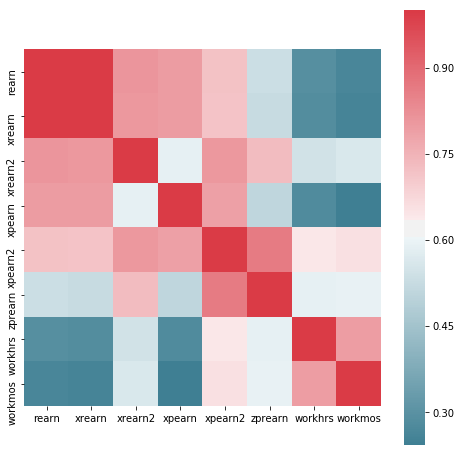

In [8]:
dataset = dataset[['rearn','xrearn','xrearn2','xpearn','xpearn2','zprearn', 'workhrs', 'workmos']]
f, ax = plt.subplots(figsize=(8, 8))
corr_data = dataset.corr()
sns.heatmap(corr_data, mask=np.zeros_like(corr_data, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [9]:
all_values = all_values[['rearn','xrearn','xrearn2','xpearn','xpearn2','zprearn', 'workhrs', 'workmos']]
all_values['rearn_dummy'] = np.where(all_values['rearn'] > 0, 1, 0)

In [10]:
dataset.describe()

,rearn,xrearn,xrearn2,xpearn,xpearn2,zprearn,workhrs,workmos
count,1.348000e+03,1.494000e+03,1494.000000,1.495000e+03,1495.000000,1501.000000,1501.000000,1501.000000
mean,3.032931e+04,3.031399e+04,132.109625,4.189653e+04,163.445236,32407.801171,33.808195,8.985343
std,6.578292e+04,6.248376e+04,113.444503,9.395059e+04,123.257225,29605.593364,19.374217,4.710391
min,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,0.000000e+00,0.000000e+00,0.000000,7.500000e+03,86.602539,7500.000000,26.000000,7.000000
50%,1.600000e+04,2.000000e+04,141.421356,3.000000e+04,173.205078,26977.791020,40.000000,12.000000
75%,3.900000e+04,3.500000e+04,187.082871,4.500000e+04,212.132034,50000.000000,42.299999,12.000000
max,1.500000e+06,1.500000e+06,1224.744873,2.500000e+06,1581.138794,100000.992200,90.000000,12.000000


Text(0,0.5,'Earnings')

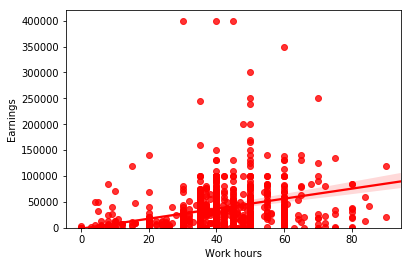

In [11]:
#Plotting the mean of workhours for each class of earners
#sns.barplot(x='earners',y='workhrs',data=dataset, palette="muted")
sns.regplot("workhrs", y="rearn", data=dataset, color= 'red')
plt.ylim(0, 420000)
plt.xlabel('Work hours')
plt.ylabel('Earnings')

153


Text(0.5,1,'Random Imputation between minimum and maximum values')

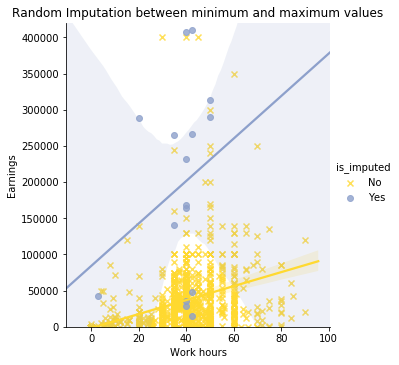

In [12]:
pd.options.mode.chained_assignment = None

#Random Imputation
missing_data_value = missing_data_value[['rearn','xrearn','xrearn2','xpearn','xpearn2','zprearn', 'workhrs', 'workmos']]
missing_data_value['is_imputed'] = 'Yes'

train = all_values
x_value = pd.DataFrame(columns = ['rearn'])
for i in range(0,153):
    c = random.randint(0,420000)
    x_value.loc[i,'rearn'] = c
    
missing_data_value['rearn'] = x_value.rearn
print(len(missing_data_value))
train['is_imputed'] = 'No'
dataset_random = train.append(missing_data_value)

sns.lmplot("workhrs", y="rearn", data=dataset_random, hue= 'is_imputed', palette="Set2_r", markers=["x", "o"])
plt.ylim(0, 420000)
plt.xlabel('Work hours')
plt.ylabel('Earnings')
plt.title('Random Imputation between minimum and maximum values')

In [13]:
#Training a logistic regression model to impute the missing values of earnings
pd.options.mode.chained_assignment = None
earnings = all_values['rearn_dummy']
new_train = all_values.drop(['rearn', 'rearn_dummy', 'is_imputed'], axis = 1)
train = new_train[['xrearn','xrearn2','xpearn','xpearn2','zprearn']]
train_list = list(train.columns)
new_train = np.array(train)

#Training a linear regression model to impute the missing values of earnings
#test = missing_data_value.drop(['rearn_dummy'], axis = 1)
missing_data_value = missing_data_value.drop(['is_imputed', 'rearn'], axis = 1)
missing_data = missing_data_value[['xrearn','xrearn2','xpearn','xpearn2','zprearn']]
missing_data = missing_data.fillna(0)
test = np.array(missing_data)


#Making models to predict missing values
model = LogisticRegression().fit(new_train, earnings)
pred = model.predict(test)

all_values['is_imputed'] = 'No'
missing_data_value['rearn_dummy'] = pred
missing_data_value['rearn'] = np.where(pred > 0, 'NaN',0)

missing_data_value['is_imputed'] = 'Yes'
dataset_logistic = all_values.append(missing_data_value)

In [14]:
dataset_logistic['rearn'] = dataset_logistic['rearn'].astype('float')
new_missing_data_value = dataset_logistic[dataset_logistic['rearn'].isnull()]
new_all_values = dataset_logistic.dropna(subset = ['rearn'])


In [15]:
len(new_missing_data_value)

149

In [16]:
new_all_values.describe()

,rearn,rearn_dummy,workhrs,workmos,xpearn,xpearn2,xrearn,xrearn2,zprearn
count,1.352000e+03,1352.000000,1352.000000,1352.000000,1.349000e+03,1349.000000,1.348000e+03,1348.000000,1352.000000
mean,3.023958e+04,0.707101,33.123743,8.801036,4.189788e+04,159.021174,3.032931e+04,127.604752,32127.801730
std,6.570613e+04,0.455261,19.890323,4.841337,9.889137e+04,128.928166,6.578292e+04,118.561231,30642.968417
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000
25%,0.000000e+00,0.000000,20.000000,6.000000,6.000000e+03,77.459663,0.000000e+00,0.000000,5999.999512
50%,1.600000e+04,1.000000,40.000000,12.000000,2.688000e+04,163.951218,1.600000e+04,126.491104,24999.998050
75%,3.900000e+04,1.000000,42.299999,12.000000,5.000000e+04,223.606796,3.900000e+04,197.484177,50000.000000
max,1.500000e+06,1.000000,90.000000,12.000000,2.500000e+06,1581.138794,1.500000e+06,1224.744873,100000.992200


In [17]:
#Training a linear regression model to impute the missing values of earnings
pd.options.mode.chained_assignment = None
earnings = new_all_values['rearn']
new_train = new_all_values.drop(['rearn', 'rearn_dummy', 'is_imputed'], axis = 1)
new_train = new_train[['xrearn','xrearn2','xpearn','xpearn2','zprearn']]
new_train = new_train.fillna(0)
train_list = list(new_train.columns)
new_train = np.array(new_train)

#Training a linear regression model to impute the missing values of earnings
#test = missing_data_value.drop(['rearn_dummy'], axis = 1)
new_missing_data_value = new_missing_data_value.drop(['is_imputed', 'rearn'], axis = 1)
missing_data = new_missing_data_value[['xrearn','xrearn2','xpearn','xpearn2','zprearn']]
missing_data = missing_data.fillna(0)
test = np.array(missing_data)


#Making models to predict missing values
model = LinearRegression().fit(new_train, earnings)
pred = model.predict(test)

new_all_values['is_imputed'] = 'No'
new_missing_data_value['rearn'] = pred
new_missing_data_value['is_imputed'] = 'Yes'
dataset_linear = new_all_values.append(new_missing_data_value)

In [18]:
print(model.coef_)
print(model.intercept_)

[ 1.00000000e+00  2.62645728e-14  4.93630135e-17 -2.45969195e-14
  1.34976442e-16]
-2.1827872842550278e-11


In [19]:
dataset_linear.describe()

,rearn,rearn_dummy,workhrs,workmos,xpearn,xpearn2,xrearn,xrearn2,zprearn
count,1.501000e+03,1501.000000,1501.000000,1501.000000,1.495000e+03,1495.000000,1.494000e+03,1494.000000,1501.000000
mean,3.017262e+04,0.736176,33.808195,8.985343,4.189653e+04,163.445236,3.031399e+04,132.109625,32407.801171
std,6.237202e+04,0.440852,19.374217,4.710391,9.395059e+04,123.257225,6.248376e+04,113.444503,29605.593364
min,-2.180375e-11,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000
25%,0.000000e+00,0.000000,26.000000,7.000000,7.500000e+03,86.602539,0.000000e+00,0.000000,7500.000000
50%,2.000000e+04,1.000000,40.000000,12.000000,3.000000e+04,173.205078,2.000000e+04,141.421356,26977.791020
75%,3.500000e+04,1.000000,42.299999,12.000000,4.500000e+04,212.132034,3.500000e+04,187.082871,50000.000000
max,1.500000e+06,1.000000,90.000000,12.000000,2.500000e+06,1581.138794,1.500000e+06,1224.744873,100000.992200


Text(0.5,1,'Imputation using Linear Regression')

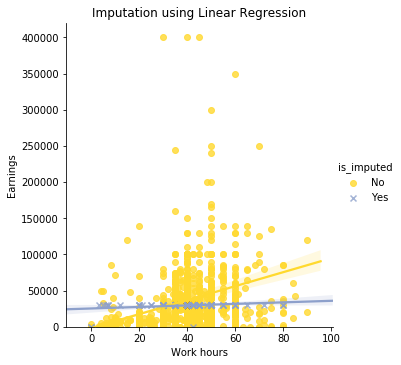

In [20]:
#Plotting the mean of workhours for each class of earners
sns.lmplot("workhrs", y="rearn", data=dataset_linear, hue= 'is_imputed', palette="Set2_r",  markers=["o", "x"])
plt.ylim(0, 420000)
plt.xlabel('Work hours')
plt.ylabel('Earnings')
plt.title('Imputation using Linear Regression')